# Deep Dream

## Loading the pretrained inception V3 model

In [1]:
from keras.applications import inception_v3

Using TensorFlow backend.


In [2]:
from keras import backend as K

In [3]:
K.set_learning_phase(0) # Disable all training specific operations since we won't training the model

In [4]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Next, we will simultaneously maximize the activation of all filters in a number of layers. Specifically, you will maximize a weighted sum of the L2 norm of the activations of a set of the activations of a set of high-level layers.

## Setting up the DeepDream configuration

In [5]:
# Dictionary mapping layer names to a coefficient quantifying how much the layer's activation
# contributes to the loss you will seek to maximize. Note that the layer names are hardcoded in the built-in Inception V3
# You can list all layer names using model.summary()
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5
}

## Defining the loss to be maximized

In [6]:
# Create a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [7]:
# Define the loss by addding layer contributions to this scalar variable
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # We avoid border artifacts by only involving non-border pixels in the loss.
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling 

## Gradient Ascent

In [8]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x





Finally, here is the actual Deep Dream algorithm.

First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than previous one by a factor 1.4 (i.e. 40% larger): we start by processing a small image and we increasingly upscale it:




Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original image should look like at the larger scale. Given a small image S and a larger image size L, we can compute the difference between the original image (assumed larger than L) resized to size L and the original resized to size S -- this difference quantifies the details lost when going from S to L.

The code above below leverages the following straightforward auxiliary Numpy functions, which all do just as their name suggests. They require to have SciPy installed.


In [9]:


import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = 'assets/hawaii.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (244, 326)
...Loss value at 0 : 1.44509
...Loss value at 1 : 2.07244
...Loss value at 2 : 2.76703
...Loss value at 3 : 3.47444
...Loss value at 4 : 4.22189
...Loss value at 5 : 4.8357
...Loss value at 6 : 5.38182
...Loss value at 7 : 6.02659
...Loss value at 8 : 6.61697
...Loss value at 9 : 7.14995
...Loss value at 10 : 7.69796
...Loss value at 11 : 8.26446
...Loss value at 12 : 8.78919
...Loss value at 13 : 9.32757
...Loss value at 14 : 9.81228


/home/abanihi/anaconda3/envs/dl-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/abanihi/anaconda3/envs/dl-gpu/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (342, 457)
...Loss value at 0 : 2.74746
...Loss value at 1 : 4.04419
...Loss value at 2 : 5.15267
...Loss value at 3 : 6.11081
...Loss value at 4 : 7.03122
...Loss value at 5 : 7.8914
...Loss value at 6 : 8.70916
...Loss value at 7 : 9.46904
Processing image shape (480, 640)
...Loss value at 0 : 2.78434
...Loss value at 1 : 4.06686
...Loss value at 2 : 5.32377
...Loss value at 3 : 6.59522
...Loss value at 4 : 8.3511


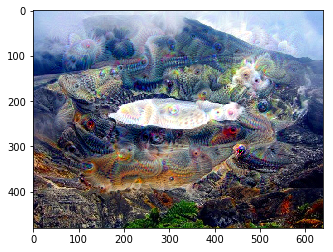

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(deprocess_image(np.copy(img)))
plt.show()